# K-Nearest Neighbors
Modify the KNN scratch code in our lecture such that:
- If the majority class of the first place is equal to the second place, then ask the algorithm to pick the next nearest neighbors as the decider
- Modify the code so it outputs the probability of the decision, where the probability is simply the class probability based on all the nearest neighbors
- Write a function which allows the program to receive a range of k, and output the cross validation score.  Last, it shall inform us which k is the best to use from a predefined range
- Put everything into a class <code>KNN(k=3)</code>.  It should have at least one method, <code>predict(X_train, X_test, y_train)</code>
--- 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

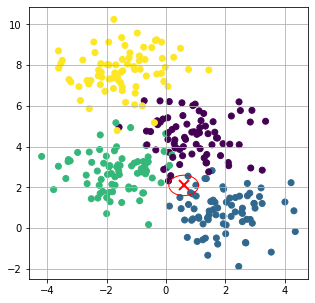

In [2]:
#let's consider the following 2D data with 4 classes
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

xfit = np.linspace(-1, 3.5)

figure = plt.figure(figsize=(5, 5))
ax = plt.axes()  #get the instance of axes from plt

ax.grid()
ax.scatter(X[:, 0], X[:, 1], c=y)

#where should this value be classified as?
ax.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

#let's say roughly 5 neighbors
circle = plt.Circle((0.6, 2.1), 0.5, color='red', fill=False)
ax.add_artist(circle)

In [3]:
#standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

#do train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [4]:
print(X_test.shape)
print(X_train.shape)
print(X_test[:, np.newaxis, :].shape)
print(X_train[np.newaxis, :, :].shape)

(90, 2)
(210, 2)
(90, 1, 2)
(1, 210, 2)


In [5]:
class KNN:
    def __init__(self, k = 3):
        self.k = k
        
        
    def create_distance_matrix(self, X_test, X_train):
        dist = X_test[:, np.newaxis, :] - X_train[np.newaxis, :, :]
        sq_dist = dist **2
        summed_dist = sq_dist.sum(axis = 2)
        sqrt_dist = np.sqrt(summed_dist)
        
        assert sqrt_dist.shape == (X_test.shape[0], X_train.shape[0]), 'dist not the right shape'
        self.distance_matrix = sqrt_dist
        return sqrt_dist
        
        
    def predict(self, X_train, X_test, y_train, y_test):
        distance_matrix = self.create_distance_matrix(X_test, X_train)
        knn_idx = distance_matrix.argsort()[:, : self.k]

        kNearest = self.k
        most_common_set = np.zeros(len(knn_idx))
        most_common_set_prob = np.zeros(len(knn_idx))
        
        for i in range(len(knn_idx)):

            binlength = len(np.bincount(y_train[knn_idx][i]))

            
            if binlength == 1: 
                most_common_set[i] = np.bincount(y_train[knn_idx][i]).argmax()
                most_common_set_prob[i] = max(np.bincount(y_train[knn_idx][i]) / np.sum(np.bincount(y_train[knn_idx][i])))
                
            
            else:
                most_common = np.bincount(y_train[knn_idx][i]).argmax()
                second_most_common = np.bincount(y_train[knn_idx][i]).argsort()[-2]
                
                if most_common != second_most_common:
                    most_common_set[i] = np.bincount(y_train[knn_idx][i]).argmax()
                    most_common_set_prob[i] = max(np.bincount(y_train[knn_idx][i]) / np.sum(np.bincount(y_train[knn_idx][i])))
                
                else:
                    kNearest += 1
                    knn_idx = self.distance_matrix.argsort()[:, : kNearest]
                    most_common = np.bincount(y_train[knn_idx][i]).argmax()
                    second_most_common = np.bincount(y_train[knn_idx][i]).argsort()[-2]
                    most_common_set_prob[i] = max(np.bincount(y_train[knn_idx][i]) / np.sum(np.bincount(y_train[knn_idx][i])))
        
        prob_average = np.sum(most_common_set_prob) / len(knn_idx)
        accuracy_score = np.sum((most_common_set == y_test) / len(y_test))
        self.accuracy_score = accuracy_score
        self.yhat = most_common_set
        
        return prob_average, accuracy_score

    
    
    def cv(self, X_train, y_train, fold, k_range):
        len_range = len(k_range)
        foldsize = round(len(X_train) / fold)
        cv_prob_set =  np.zeros((len_range, fold))
        cv_accuracy_set = np.zeros((len_range, fold))
        
        
        for k_idx, k in enumerate(k_range):
            self.k = k
        
            for fold_idx, i in enumerate(range(0, len(X_train), foldsize)):
                X_val = X_train[i: i+foldsize]
                y_val = y_train[i: i+foldsize]
                X_train_ = np.concatenate((X_train[:i ], X_train[i+foldsize: ]))
                y_train_ = np.concatenate((y_train[:i ], y_train[i+foldsize: ]))
                cv_prob_set[k_idx, fold_idx], cv_accuracy_set[k_idx, fold_idx]  =  self.predict(X_train_, X_val, y_train_, y_val)
#                 print(f"k: {k}, fold: {fold_idx}") 
#                 print(cv_prob_set)
#                 print(cv_accuracy_set)

            avg_prob = np.mean(cv_prob_set, axis = 1)
            avg_accuracy = np.mean(cv_accuracy_set, axis = 1)
        
        print()
        print(f"Average probability for {k_range} neighbors is {avg_prob}")
        print()
        print(f"Average accuracy for {k_range} neighbors is {avg_accuracy}")
        best_k_idx = np.argmax(avg_accuracy)
        print(f"The best k: {k_range[best_k_idx]} yielding the accuracy rate at {avg_accuracy[best_k_idx]}")   
        
        
        self.k_range = k_range
        self.avg_prob_set =  avg_prob
        self.avg_accuracy_set = avg_accuracy

---

## Try cross-validation of 10 folds and k-neighbor ranges from 3 - 15 on training data

In [6]:
model = KNN()
model.cv(X_train, y_train, fold = 10, k_range = range(3,15))


Average probability for range(3, 15) neighbors is [0.95714286 0.95071429 0.94904762 0.94263039 0.93767007 0.93108466
 0.92804233 0.92160173 0.91904762 0.91642247 0.91451596 0.91414966]

Average accuracy for range(3, 15) neighbors is [0.93333333 0.92380952 0.92380952 0.93333333 0.93333333 0.92380952
 0.92857143 0.92857143 0.92857143 0.91428571 0.92857143 0.91904762]
The best k: 3 yielding the accuracy rate at 0.9333333333333336


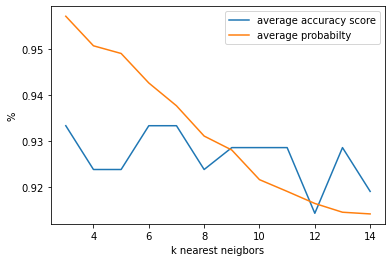

In [7]:
plt.plot(model.k_range, model.avg_accuracy_set, label = 'average accuracy score')
plt.plot(model.k_range, model.avg_prob_set, label = 'average probabilty')
plt.xlabel("k nearest neigbors")
plt.ylabel('%')
plt.legend()

### Using the best k nearest neighbor of 3 to predict the test dataset and check accuracy

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [9]:
model1_test = KNN(k=3)

In [10]:
model1_test.predict(X_train, X_test, y_train, y_test)

(0.9592592592592593, 0.9444444444444444)

Text(0.5, 1.0, 'Accuracy score: 0.94')

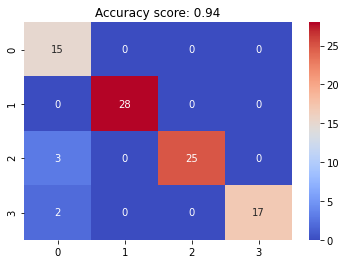

In [11]:
sns.heatmap(confusion_matrix(y_true = y_test, y_pred = model1_test.yhat ), cmap = 'coolwarm', annot= True)
plt.title(f"Accuracy score: {round(model1_test.accuracy_score, 2)}")

## Try cross-validation of 3 folds and k-neighbor ranges from 2 - 10

In [12]:
model2 = KNN()
model2.cv(X_train, y_train, fold = 3, k_range = range(2,10))


Average probability for range(2, 10) neighbors is [0.96031746 0.96031746 0.94714286 0.9447619  0.92859033 0.92234505
 0.92308201 0.91892496]

Average accuracy for range(2, 10) neighbors is [0.92857143 0.92857143 0.90952381 0.91428571 0.93333333 0.93333333
 0.91904762 0.92380952]
The best k: 6 yielding the accuracy rate at 0.933333333333333


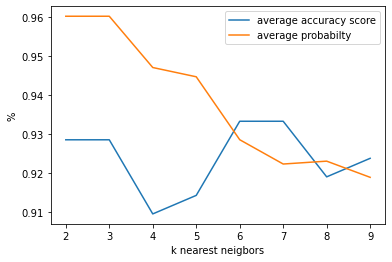

In [13]:
plt.plot(model2.k_range, model2.avg_accuracy_set, label = 'average accuracy score')
plt.plot(model2.k_range, model2.avg_prob_set, label = 'average probabilty')
plt.xlabel("k nearest neigbors")
plt.ylabel('%')
plt.legend()

### Using the best k nearest neighbor of 6 to predict the test dataset and check accuracy

In [17]:
model2_test = KNN(k=6)

In [18]:
model2_test.predict(X_train, X_test, y_train, y_test)

(0.9441798941798941, 0.9333333333333333)

Text(0.5, 1.0, 'Accuracy score: 0.93')

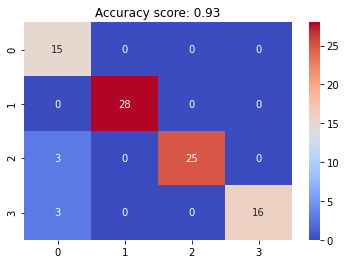

In [19]:
sns.heatmap(confusion_matrix(y_true = y_test, y_pred = model2_test.yhat ), cmap = 'coolwarm', annot= True)
plt.title(f"Accuracy score: {round(model2_test.accuracy_score, 2)}")

---
## Summary from comparing 2 models of 1) 10 folds with k ranges of (3-15) and 2) 3 folds with k ranges of (2-10)
- The first model with 10-fold cross valdiataion and the best k neighbor of 3 yileds the the accuracy score of ~93% on train data and ~94% on test data
- The second model with 3-fold cross valdiataion and the best k neighbors of 6 can yields almost the same result of accuracy score on train and test data at ~ 93%
- In terms of probability of observing the predicted classes, the first model yields the higher probability at ~ 96% while the second model yields slightly less at 93%
